In [2]:
import sys
import glob
import os, os.path
import subprocess
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# Define ice extent

In [3]:
INPUT_FILENAME='thk_DST.nc' # File produced by "remap_cism.sh"

In [4]:
ds = xr.open_dataset(INPUT_FILENAME)

In [6]:
ds.load()

<xarray.Dataset>
Dimensions:   (nv4: 4, time: 1, x: 1681, y: 2881)
Coordinates:
    lon       (y, x) float64 -56.79 -56.77 -56.76 -56.74 -56.72 -56.71 ...
    lat       (y, x) float64 58.27 58.27 58.27 58.28 58.28 58.28 58.28 58.28 ...
  * time      (time) float64 0.0
Dimensions without coordinates: nv4, x, y
Data variables:
    lon_bnds  (y, x, nv4) float64 -56.79 -56.78 -56.78 -56.8 -56.78 -56.76 ...
    lat_bnds  (y, x, nv4) float64 58.26 58.27 58.27 58.27 58.27 58.27 58.28 ...
    thk       (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    CDI:               Climate Data Interface version 1.7.2 (http://mpimet.mp...
    Conventions:       CF-1.3
    history:           Mon Oct 22 08:17:36 2018: cdo remapbil,/gpfs/u/home/lv...
    cesmYMD:           19800101
    cesmTOD:           0
    glcYMD:            19800101
    glcTOD:            0
    elapsed_days:      365
    time_period_freq:  year_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    

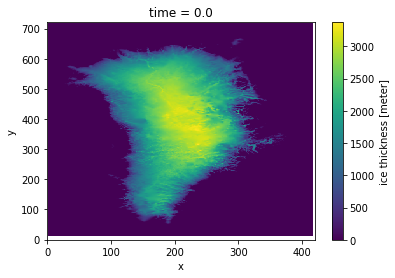

In [7]:
ds['thk'][0,::4,::4].plot()

In [8]:
ds['extent'] = xr.where(ds['thk'] > 1, 1.0, 0.0)

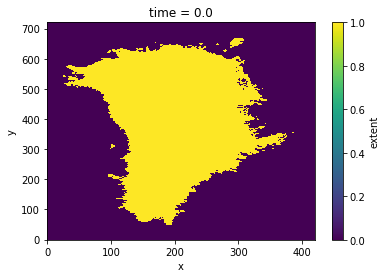

In [9]:
ds['extent'][:,::4,::4].plot()

# Drop thickness

In [10]:
ds = ds.drop('thk')

# Attributes

In [11]:
attrs = ds['extent'].attrs
attrs['long_name'] = 'Ice extent based on CISM thickness map'
attrs['units'] = 'fraction'

attrs = ds.attrs
attrs['institution'] ="NCAR and Utrecht University"
attrs['contact'] = "L.vankampenhout@uu.nl"
attrs['model'] = "CESM 2.0 in atmosphere only mode"
attrs['comment'] = "Topography SRF_GIMP was assumed in the downscaling procedure"

# Add surface topography

In [20]:

target_elev_fname = '/gpfs/p/work/lvank/SMBmip/MARv3.9-yearly-ERA-Interim-1980.nc'
target_elev_varname = 'SRF_GIMP'

target_elev_fname = '/gpfs/fs1/work/lvank/SMBmip/1km-ISMIP6.nc'
target_elev_varname = 'SRF'

with xr.open_dataset(target_elev_fname, decode_times=False) as ds2:
    ds['SRF'] = ds2[target_elev_varname]

    attrs = ds['SRF'].attrs
    attrs['long_name'] = 'Topographic height used in downscaling'

# Add original topography

In [21]:
INPUT_FILENAME='Dst_TOPO_COL.nc' # File produced by "remap_TOPO_COL.sh"

In [22]:
with xr.open_dataset(INPUT_FILENAME) as ds2:
    da = ds2['TOPO_COL'].squeeze()
    ds['TOPO_COL'] = da

In [23]:
ds = ds.squeeze()
ds.load()

<xarray.Dataset>
Dimensions:   (X: 1681, Y: 2881, nv4: 4, x: 1681, y: 2881)
Coordinates:
    lon       (y, x) float64 -56.79 -56.77 -56.76 -56.74 -56.72 -56.71 ...
    lat       (y, x) float64 58.27 58.27 58.27 58.28 58.28 58.28 58.28 58.28 ...
    time      float64 0.0
  * X         (X) float32 -720000.0 -719000.0 -718000.0 -717000.0 -716000.0 ...
  * Y         (Y) float32 -3450000.0 -3449000.0 -3448000.0 -3447000.0 ...
Dimensions without coordinates: nv4, x, y
Data variables:
    lon_bnds  (y, x, nv4) float64 -56.79 -56.78 -56.78 -56.8 -56.78 -56.76 ...
    lat_bnds  (y, x, nv4) float64 58.26 58.27 58.27 58.27 58.27 58.27 58.28 ...
    extent    (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SRF       (Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    TOPO_COL  (y, x) float32 nan nan nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    CDI:               Climate Data Interface version 1.7.2 (http://mpimet.mp...
    Conventions:      

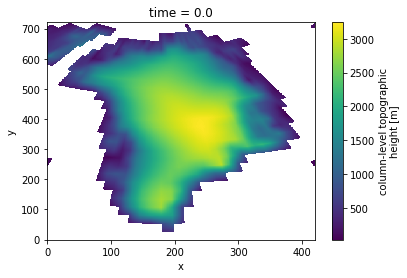

In [24]:
ds['TOPO_COL'][::4,::4].plot()

In [25]:
attrs = ds['TOPO_COL'].attrs
attrs['long_name'] = 'Atmospheric topographic height'

# Save output

In [26]:
ds.data_vars.keys()

KeysView(Data variables:
    lon_bnds  (y, x, nv4) float64 -56.79 -56.78 -56.78 -56.8 -56.78 -56.76 ...
    lat_bnds  (y, x, nv4) float64 58.26 58.27 58.27 58.27 58.27 58.27 58.28 ...
    extent    (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SRF       (Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    TOPO_COL  (y, x) float32 nan nan nan nan nan nan nan nan nan nan nan nan ...)

In [27]:
outfile = "metadata_CESM_uncompressed.nc"

if (True):
    ds.to_netcdf(outfile) # no compression b/c that is very slow. Can add it later with CDO. 

else:
    ds.to_netcdf(outfile, 
        encoding={
            varname: {'zlib': True, 'complevel': 9} for varname in (list(ds.data_vars.keys()) + ['lat','lon'])
        })   

/glade/work/bitz/miniconda3/envs/pangeo/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
